<a href="https://colab.research.google.com/github/Udaykamal2005/OIBSIP/blob/main/Project_4_Proposal_Level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: install (optional) libraries we'll use
!pip install -q nltk scikit-learn seaborn wordcloud

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
print("Installed & NLTK resources downloaded.")


Installed & NLTK resources downloaded.


In [ ]:
# Cell 2: upload CSV (uses your preferred flow but is robust)
from google.colab import files
import io, pandas as pd, os

print("Upload your CSV file (example: 'apps.csv'):")
uploaded = files.upload()

if not uploaded:
    raise RuntimeError("No file uploaded. Please upload the dataset CSV.")

# auto-pick first uploaded file
filename = list(uploaded.keys())[0]
print("Using uploaded file:", filename)

# try reading normally; fallback to latin1 if needed
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), low_memory=False)
except Exception as e:
    print("Standard read failed, retrying with latin1 encoding...", str(e))
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1', low_memory=False)

print("Loaded dataframe shape:", df.shape)
print("Columns:")
print(df.columns.tolist())
display(df.head())


Upload your CSV file (example: 'apps.csv'):


Saving apps.csv to apps.csv
Using uploaded file: apps.csv
Loaded dataframe shape: (9659, 14)
Columns:
['Unnamed: 0', 'App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
# Cell 3: quick info and missing values
print("Shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))


Shape: (9659, 14)

Data types:
Unnamed: 0          int64
App                object
Category           object
Rating            float64
Reviews             int64
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Missing values per column (top 20):


,0
Rating,1463
Size,1227
Current Ver,8
Android Ver,2
Type,1
App,0
Reviews,0
Category,0
Unnamed: 0,0
Installs,0


In [ ]:
# Cell 4: normalize column names, drop exact duplicates
df.columns = [c.strip() for c in df.columns]
print("Columns now:", df.columns.tolist())

# drop fully duplicate rows (if any)
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped {before-after} exact duplicate rows. New shape: {df.shape}")


Columns now: ['Unnamed: 0', 'App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
Dropped 0 exact duplicate rows. New shape: (9659, 14)


In [ ]:
# Cell 5: robust parsing for Reviews, Installs, Price, Size, Last Updated
import numpy as np
import re
from datetime import datetime

# Rating safe numeric
if 'Rating' in df.columns:
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Reviews -> numeric
if 'Reviews' in df.columns:
    df['Reviews'] = pd.to_numeric(df['Reviews'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)

# Installs -> remove '+' and ',' and convert to int; if ranges like '1,000,000+' -> 1000000
if 'Installs' in df.columns:
    def parse_installs(x):
        try:
            s = str(x).strip().replace('+','').replace(',','')
            return int(s) if s!='' and s!='nan' else np.nan
        except:
            return np.nan
    df['Installs_raw'] = df['Installs']
    df['Installs'] = df['Installs'].apply(parse_installs).fillna(0).astype(int)

# Price -> remove $ and convert
if 'Price' in df.columns:
    df['Price'] = df['Price'].astype(str).str.replace('$','').str.strip()
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0.0)

# Size -> convert '19M', '14k', 'Varies with device' -> MB float or np.nan
if 'Size' in df.columns:
    def parse_size(s):
        if pd.isna(s): return np.nan
        s = str(s).strip().lower()
        if s in ['varies with device', 'varies']: return np.nan
        try:
            if s.endswith('k'):
                return float(s[:-1]) / 1024.0  # convert KB to MB
            if s.endswith('m'):
                return float(s[:-1])
            if s.endswith('gb'):
                return float(s[:-2]) * 1024.0
            # fallback: extract number
            m = re.search(r'([\d\.]+)', s)
            return float(m.group(1)) if m else np.nan
        except:
            return np.nan
    df['Size_MB'] = df['Size'].apply(parse_size)

# Last Updated -> datetime
if 'Last Updated' in df.columns:
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

print("After parsing: columns added/updated -> Reviews, Installs, Price, Size_MB, Rating, Last Updated")
display(df[['App','Category','Rating','Reviews','Installs','Price','Size_MB','Last Updated']].head())


After parsing: columns added/updated -> Reviews, Installs, Price, Size_MB, Rating, Last Updated


,App,Category,Rating,Reviews,Installs,Price,Size_MB,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,10000,0.0,19.0,2018-01-07
1,Coloring book moana,ART_AND_DESIGN,3.9,967,500000,0.0,14.0,2018-01-15
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,5000000,0.0,8.7,2018-08-01
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,50000000,0.0,25.0,2018-06-08
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,100000,0.0,2.8,2018-06-20


Top categories:


,count
Category,
FAMILY,1832
GAME,959
TOOLS,827
BUSINESS,420
MEDICAL,395
PERSONALIZATION,376
PRODUCTIVITY,374
LIFESTYLE,369
FINANCE,345


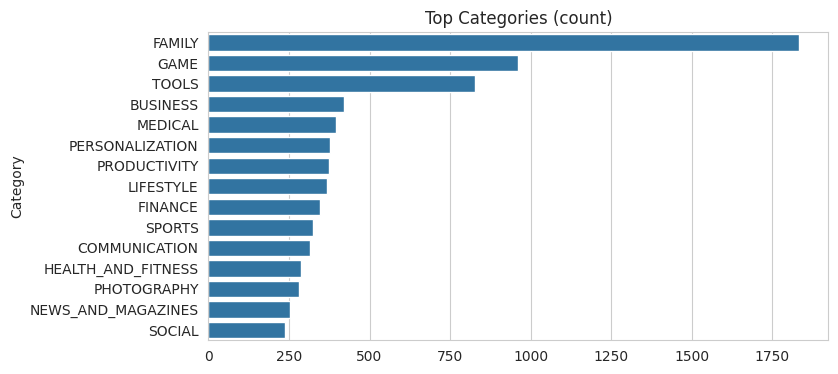


Top 10 apps by Installs:


,App,Category,Installs,Rating,Reviews
2977,Google News,NEWS_AND_MAGAZINES,1000000000,3.9,877635
2012,Google+,SOCIAL,1000000000,4.2,4831125
1356,Subway Surfers,GAME,1000000000,4.5,27722264
152,Google Play Books,BOOKS_AND_REFERENCE,1000000000,3.9,1433233
2908,YouTube,VIDEO_PLAYERS,1000000000,4.3,25655305
2003,Instagram,SOCIAL,1000000000,4.5,66577313
2930,Google Play Movies & TV,VIDEO_PLAYERS,1000000000,3.7,906384
2191,Google Photos,PHOTOGRAPHY,1000000000,4.5,10858556
2429,Google Street View,TRAVEL_AND_LOCAL,1000000000,4.2,2129689
701,Google Play Games,ENTERTAINMENT,1000000000,4.3,7165362


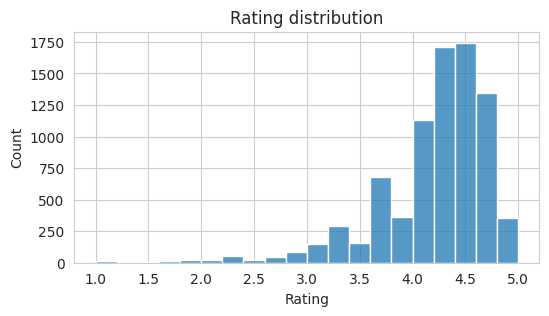

In [ ]:
# Cell 6: EDA - category counts, top apps by installs, rating distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Category counts
if 'Category' in df.columns:
    top_cats = df['Category'].value_counts().head(15)
    print("Top categories:")
    display(top_cats)
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_cats.values, y=top_cats.index)
    plt.title("Top Categories (count)")
    plt.show()

# Top apps by installs
print("\nTop 10 apps by Installs:")
display(df.sort_values('Installs', ascending=False).head(10)[['App','Category','Installs','Rating','Reviews']])

# Rating distribution (skip NaN)
if 'Rating' in df.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(df['Rating'].dropna(), bins=20)
    plt.title("Rating distribution")
    plt.show()


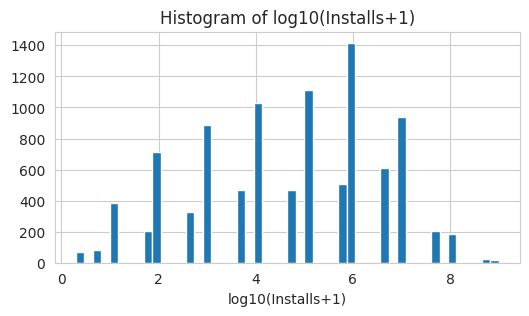

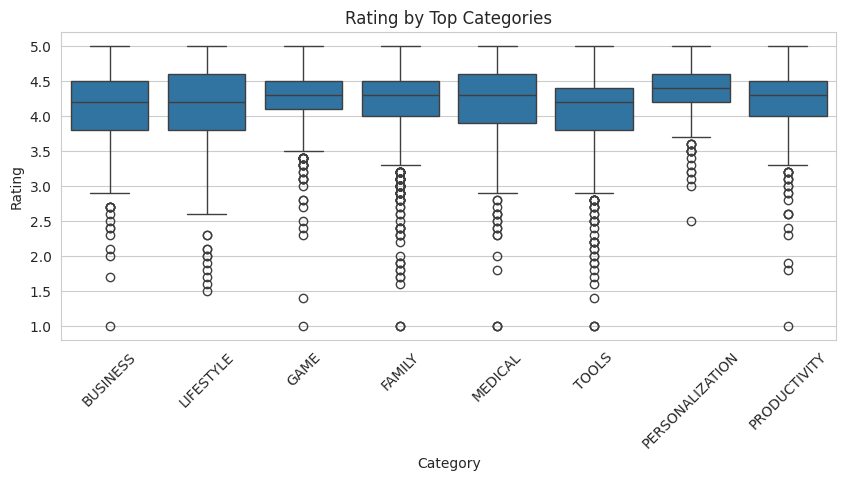

In [ ]:
# Cell 7: installs distribution and boxplot rating by category (top categories)
import numpy as np

if 'Installs' in df.columns:
    vals = df['Installs'].replace(0, np.nan).dropna()
    plt.figure(figsize=(6,3))
    plt.hist(np.log10(vals + 1), bins=50)
    plt.title('Histogram of log10(Installs+1)')
    plt.xlabel('log10(Installs+1)')
    plt.show()

# Boxplot of Rating by top categories (if rating exists)
if 'Rating' in df.columns and 'Category' in df.columns:
    topcat = df['Category'].value_counts().head(8).index.tolist()
    plt.figure(figsize=(10,4))
    sns.boxplot(x='Category', y='Rating', data=df[df['Category'].isin(topcat)])
    plt.xticks(rotation=45)
    plt.title('Rating by Top Categories')
    plt.show()


Free vs Paid counts:


,count
Type,
Free,8902
Paid,756


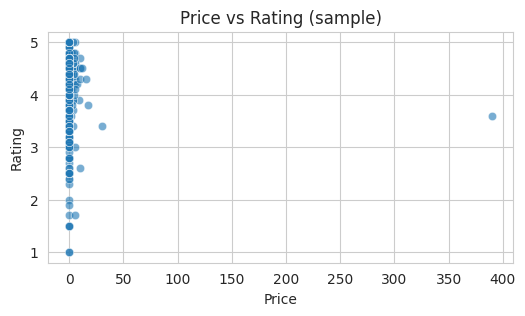

In [ ]:
# Cell 8: Price vs Rating scatter and count free vs paid
if 'Type' in df.columns:
    print("Free vs Paid counts:")
    display(df['Type'].value_counts())

# Price vs Rating scatter (if Price present)
if 'Price' in df.columns and 'Rating' in df.columns:
    plt.figure(figsize=(6,3))
    sns.scatterplot(data=df.sample(n=min(1000,len(df)), random_state=1), x='Price', y='Rating', alpha=0.6)
    plt.title('Price vs Rating (sample)')
    plt.show()


In [ ]:
# Cell 9: genres column may have multiple genres separated by ';' or ','
if 'Genres' in df.columns:
    # split on ';' or comma
    s = df['Genres'].astype(str).str.replace(';',',')
    exploded = s.str.split(',').explode().str.strip().value_counts()
    print("Top Genres:")
    display(exploded.head(20))


Top Genres:


,count
Genres,
Tools,827
Education,678
Entertainment,592
Business,420
Medical,395
Personalization,376
Productivity,374
Lifestyle,370
Finance,345


,Rating,Reviews,Installs,Price,Size_MB
count,8196.000000,9.659000e+03,9.659000e+03,9659.000000,8432.000000
mean,4.173243,2.165926e+05,7.777507e+06,1.099299,20.395289
std,0.536625,1.831320e+06,5.375828e+07,16.852152,21.827542
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.008500
25%,4.000000,2.500000e+01,1.000000e+03,0.000000,4.600000
50%,4.300000,9.670000e+02,1.000000e+05,0.000000,12.000000
75%,4.500000,2.940100e+04,1.000000e+06,0.000000,28.000000
max,5.000000,7.815831e+07,1.000000e+09,400.000000,100.000000


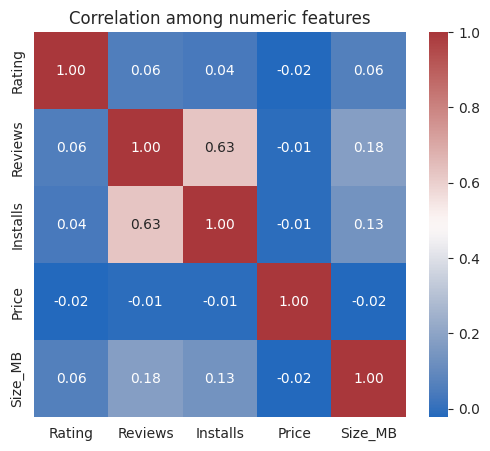

In [ ]:
# Cell 10: correlation among numerical features
num_cols = [c for c in ['Rating','Reviews','Installs','Price','Size_MB'] if c in df.columns or c in df.columns]
num_df = df[[c for c in ['Rating','Reviews','Installs','Price','Size_MB'] if c in df.columns]].copy()
num_df = num_df.dropna(how='all')
if not num_df.empty:
    display(num_df.describe())
    plt.figure(figsize=(6,5))
    sns.heatmap(num_df.corr(), annot=True, fmt='.2f', cmap='vlag')
    plt.title("Correlation among numeric features")
    plt.show()
else:
    print("Not enough numeric data for correlation.")


In [ ]:
# Cell 11: create a simple target for classification: popularity bucket
import numpy as np

# safe installs column check
if 'Installs' in df.columns:
    # define buckets: low(<1k), medium(1k-100k), high(100k-1M), very_high(>1M)
    def pop_bucket(x):
        if x <= 1000: return 'low'
        if x <= 100000: return 'medium'
        if x <= 1000000: return 'high'
        return 'very_high'
    df['pop_bucket'] = df['Installs'].apply(pop_bucket)
    print("pop_bucket value counts:")
    display(df['pop_bucket'].value_counts())
else:
    print("Installs not present; cannot create pop_bucket.")


pop_bucket value counts:


,count
pop_bucket,
medium,3080
low,2679
very_high,1978
high,1922


In [ ]:
# Cell 12: Predict Rating (drop NaN Ratings) - RandomForestRegressor baseline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Keep only rows with Rating
if 'Rating' in df.columns:
    df_reg = df.dropna(subset=['Rating']).copy()
    # features: Reviews, Installs, Price, Size_MB (only those present)
    features = [c for c in ['Reviews','Installs','Price','Size_MB'] if c in df_reg.columns]
    if len(features) == 0:
        raise RuntimeError("No numeric features available for regression. See feature list.")
    X = df_reg[features].fillna(0)
    y = df_reg['Rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    print("Training RandomForestRegressor on features:", features)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = mse**0.5 # Calculate RMSE by taking the square root of MSE
    r2 = r2_score(y_test, preds)
    print(f"Regression results -- RMSE: {rmse:.4f}, R2: {r2:.4f}")
else:
    print("No Rating column to model.")

Training RandomForestRegressor on features: ['Reviews', 'Installs', 'Price', 'Size_MB']
Regression results -- RMSE: 0.5609, R2: -0.0217


In [ ]:
# Cell 13: classification example (popularity bucket)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

if 'pop_bucket' in df.columns:
    df_clf = df.dropna(subset=['pop_bucket']).copy()
    features = [c for c in ['Reviews','Price','Size_MB'] if c in df_clf.columns]
    # include Installs as numeric too (but it's target-related — use with caution)
    if 'Installs' in df_clf.columns:
        features.append('Installs')
    if not features:
        print("No features available for classification.")
    else:
        X = df_clf[features].fillna(0)
        y = df_clf['pop_bucket']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        ypred = clf.predict(X_test)
        print("Classification report:")
        print(classification_report(y_test, ypred))
        print("Confusion matrix:")
        display(confusion_matrix(y_test, ypred))
else:
    print("pop_bucket target not found. Run the target creation cell.")


Classification report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       384
         low       1.00      1.00      1.00       536
      medium       1.00      1.00      1.00       616
   very_high       1.00      1.00      1.00       396

    accuracy                           1.00      1932
   macro avg       1.00      1.00      1.00      1932
weighted avg       1.00      1.00      1.00      1932

Confusion matrix:


array([[384,   0,   0,   0],
       [  0, 536,   0,   0],
       [  0,   0, 616,   0],
       [  0,   0,   0, 396]])